# CLASSIFICATION MODEL

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


## Load Final Dataset

In [2]:
df_train = pd.read_csv("../data/train_final.csv")
df_test  = pd.read_csv("../data/test_final.csv")

df_train.shape, df_test.shape



((9309, 6), (458, 6))

## Text Cleaning Function

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


## Creating Combined Text

In [4]:
TEXT_COLUMNS = ["title", "description", "input_format", "output_format"]

# Replace missing values with empty strings
for col in TEXT_COLUMNS:
    df_train[col] = df_train[col].fillna("")
    df_test[col] = df_test[col].fillna("")

# Combine all text fields
df_train["combined_text"] = (
    df_train["title"] + " " +
    df_train["description"] + " " +
    df_train["input_format"] + " " +
    df_train["output_format"]
)

df_test["combined_text"] = (
    df_test["title"] + " " +
    df_test["description"] + " " +
    df_test["input_format"] + " " +
    df_test["output_format"]
)



## Clean the Text

In [5]:
df_train["clean_text"] = df_train["combined_text"].apply(clean_text)
df_test["clean_text"]  = df_test["combined_text"].apply(clean_text)



## Loading TF-IDF Vectorizer & Transform

In [6]:
vectorizer = joblib.load("../models/tfidf_vectorizer.pkl")

X_train = vectorizer.transform(df_train["clean_text"])
X_test  = vectorizer.transform(df_test["clean_text"])



## Defining Target Variable

In [7]:
y_train = df_train["difficulty"]
y_test  = df_test["difficulty"]



## MODEL COMPARISON

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

results = []
models = {}

## Logistic Regression

In [9]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

results.append(("Logistic Regression", accuracy_score(y_test, lr_pred)))
models["Logistic Regression"] = lr

## Random Forest Classifier

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

results.append(("Random Forest", accuracy_score(y_test, rf_pred)))
models["Random Forest"] = rf



## Support Vector Machine (SVM)

In [11]:
svm = LinearSVC(class_weight="balanced")

svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

results.append(("SVM (Linear)", accuracy_score(y_test, svm_pred)))
models["SVM (Linear)"] = svm




## Accuracy Comparison Table

In [12]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df


,Model,Accuracy
0,Logistic Regression,0.609170
1,Random Forest,0.663755
2,SVM (Linear),0.626638


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


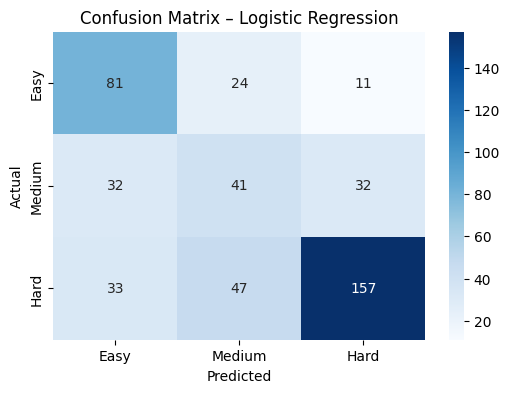

In [14]:
lr_pred = lr.predict(X_test)

cm_lr = confusion_matrix(
    y_test,
    lr_pred,
    labels=["Easy", "Medium", "Hard"]
)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Easy", "Medium", "Hard"],
    yticklabels=["Easy", "Medium", "Hard"]
)

plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


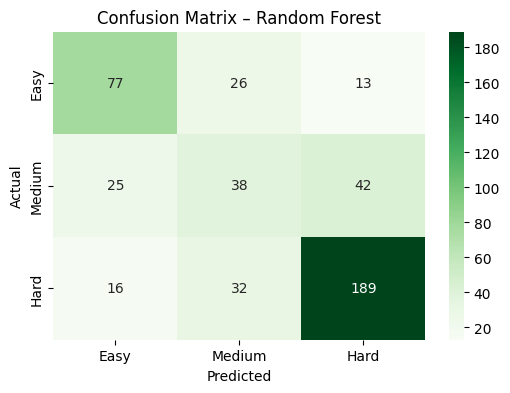

In [15]:
rf_pred = rf.predict(X_test)

cm_rf = confusion_matrix(
    y_test,
    rf_pred,
    labels=["Easy", "Medium", "Hard"]
)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Easy", "Medium", "Hard"],
    yticklabels=["Easy", "Medium", "Hard"]
)

plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


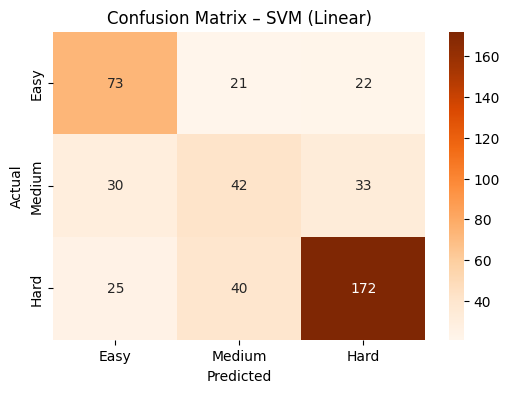

In [16]:
svm_pred = svm.predict(X_test)

cm_svm = confusion_matrix(
    y_test,
    svm_pred,
    labels=["Easy", "Medium", "Hard"]
)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Easy", "Medium", "Hard"],
    yticklabels=["Easy", "Medium", "Hard"]
)

plt.title("Confusion Matrix – SVM (Linear)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Selected: Random Forest Classifier
### Confusion matrix analysis reveals that Random Forest provides the strongest class separation, with fewer extreme misclassifications between Easy and Hard problems. Logistic Regression exhibits higher ambiguity around the Medium class, while SVM achieves intermediate performance. These observations, combined with accuracy results, motivated the selection of Random Forest as the final classification model.

## Final save cell

In [17]:
final_classifier = rf   # Random Forest chosen
joblib.dump(final_classifier, "../models/difficulty_classifier.pkl")


['../models/difficulty_classifier.pkl']